# Final DSCI 100 Project

## Predicting Subscription Status Based on Age and Playtime

This is the final DSCI 100 project, working on predicting a player's subscription status based on the amount of hours spent playing UBC's *MineCraft* and their age.

## 1. Introduction

**Context:**   
A research group in UBC Computer Science – led by Frank Wood – is collecting data about how people play video games. They set up a Minecraft server, and they need to target their recruitment efforts.

**Question:**  
The broad question answered is **“What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?”**
A more specific question we want to answer is **“Can a player’s age and number of played hours predict whether they will subscribe to a game-related newsletter?”**

## 2. Method and Results

**Data description:**
The data set "players.csv" has 196 players and 7 variables, and contains information about players who participated in UBC's Minecraft Research Project. Each row represents an individual player and there are **7** main variables:
- **experience**: The player's experience level in Minecraft (type: character)
- **subscribe**: Indicates whether or not the player subscribed to the game (type: logical)
- **hashedEmail**: The player's anonymous identity (type: character)
- **played_hours**: The number of hours the player spent playing on the server (type: double)
- **name**: The player's name (type: character)
- **gender**: The player's gender (type: character)
- **Age**: The player's age (type: double)

The variable *subscribe* is our response variable. It represents whether a player has subscribed to the game-related newsletter or not. By examining the *Age* and *played_hours* variables, we can gain insight into the age range of players who subscribe the most, and also their according playing times on MineCraft.


**Method:**

Since we are predicting a categorical variable (whether or not they subscribe to a game-related newsletter), KNN classification would be a suitable method due to its strengths with categorical data and its properties, which require minimal assumptions about the shape of the data. Once the “players.csv” data set is loaded in, wrangling will occur to make the dataset clean and ready for modelling. This wrangling entails creating a new dataframe with desired variables, converting subscription status into a factor and accounting for N/A values. Summary statistics will then be calculated, including mean, median and standard deviation. The data will also be visualized in order to explore potential trends that may be useful for our analysis.
The dataset will be split into a training set (75%) and a test set (25%). The KNN classification model will be evaluated by testing different values of K through a 5-fold cross-validation. The K value with the highest accuracy would be used.

In [17]:
#Load in tidyverse library
library(tidyverse)
library(tidymodels)
library(themis)
#Reads in players.csv from a url so it is reproducible always
players <- read_csv("https://raw.githubusercontent.com/strikerjoseph734-glitch/individual_planning_project/refs/heads/main/Data/players.csv")

head(players, n = 10)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


Now to select desired variables and wrangle them:

In [18]:
players_wrangled <- players |> 
    #Selects desired columns
    select(subscribe, played_hours, Age) |>
    #Filters for values (gets rid of N/A)
    filter(!is.na(played_hours), !is.na(Age),!is.na(subscribe))|>
    #Converts subscribe into a factor
    mutate(subscribe = factor(subscribe))
    
#Displays the first 10 rows of the dataframe
head(players_wrangled, 10)


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17
TRUE,0.0,19
FALSE,0.0,21
TRUE,0.1,47


Now our data has been wrangled, let's calculate our summary statistics:

In [19]:
#Counts number of rows (# of players) in the wrangled data
player_count <- count(players_wrangled, name = "player_count")
player_count

#Summarise to calculate summary statistics for age and hours played
age_summary <- players_wrangled |>
    summarise(mean_age = round(mean(Age), 2),
              median_age = median(Age),
              min_age = min(Age),
              max_age = max(Age),
              stdev = sd(Age),
              )
age_summary

hours_summary <- players_wrangled |>
    summarise(mean_played_hours = round(mean(played_hours), 2),
            median_played_hours = median(played_hours),
            min_played_hours = min(played_hours),
            max_played_hours = max(played_hours),
            stdev = sd(played_hours),
            )
hours_summary

#Percent proportions of those subscribed and not subscribed
subscribe_pct <- players_wrangled |>
  count(subscribe) |>
  mutate(percentage = round(n / sum(n) * 100, 2))|>
  rename(number = n)

subscribe_pct

player_count
<int>
194


mean_age,median_age,min_age,max_age,stdev
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21.14,19,9,58,7.389687


mean_played_hours,median_played_hours,min_played_hours,max_played_hours,stdev
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.9,0.1,0,223.1,28.49793


subscribe,number,percentage
<fct>,<int>,<dbl>
FALSE,52,26.8
TRUE,142,73.2


Now we have summarized our data, it is important to visualize it in order to view any potential trends. Because two numeric variables are being compared, a **scatter plot** will be used, with the colour of the point indicating whether a player has subscribed or not. 

Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_point()`).”


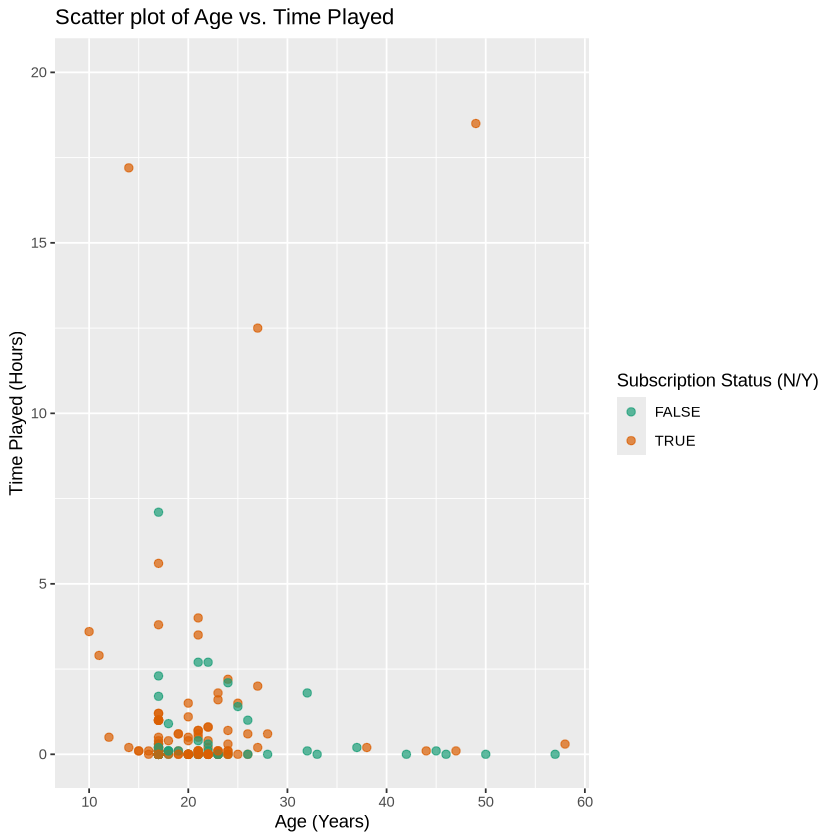

In [20]:
#Imports R Color Brewer library to colour the points
library(RColorBrewer)

hours_age_plot <- players_wrangled |> ggplot(aes(x = Age, y = played_hours, color = subscribe))+
    #Sets transparency for better visibility
    geom_point(alpha = 0.7, size = 2)+
    #Sets color palette as Dark2
    scale_color_brewer(palette = "Dark2")+
    #Axes, legend, graph titles
    labs(title = "Scatter plot of Age vs. Time Played",
         x = "Age (Years)",
         y = "Time Played (Hours)",
         color = "Subscription Status (N/Y)"
         )+
    #Sets a limit on the Y-axis to get rid of outliers and to get a better visualization of the graph
    ylim(0,20)

hours_age_plot

After limiting the Y-axis to remove outlier values, it appears that both subscribed and non-subscribed players tend to be quite young and have low playtimes. It is also clear that the majority of players are subscribed, meaning that to build an accurate predictive model, upsampling on non-subscribed players will be needed.

We want to split the data between 75% training and 25% test set. The **initial_split** function shuffles the data before splitting and stratifies the data by the class label. Shuffling the data ensures that any ordering present in the data doesn't influence the data that ends up in the graining and testing sets. Stratifying the data by the class label ensures that roughly the same proportion of each class ends up in both the training and test sets.

In [21]:
set.seed(100)

players_split <- initial_split(players_wrangled, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

glimpse(players_train)
glimpse(players_test)

Rows: 145
Columns: 3
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.0, 0.1, 0.1, 0.0, 1.4, 0.0, 0.0, 0.9, 0.0, 0.1, 0.…
$ Age          <dbl> 17, 21, 17, 18, 33, 25, 24, 23, 18, 42, 22, 37, 21, 23, 1…
Rows: 49
Columns: 3
$ subscribe    <fct> TRUE, FALSE, TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, T…
$ played_hours <dbl> 0.0, 0.0, 0.6, 0.6, 0.0, 0.4, 0.1, 0.1, 0.1, 53.9, 0.0, 0…
$ Age          <dbl> 19, 22, 19, 28, 23, 20, 17, 23, 15, 17, 22, 17, 17, 28, 1…


We create the standardization preprocessing using **only our training data** to ensure that our test data doesn't influence any aspect of our model training.

In [22]:
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())|>
    step_upsample(subscribe)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) 
players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [36]:
set.seed(100)

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
#players_vfold

- The classifier is tuned by searching over a range of possible k values, which in this case is 1 to 20.
- Using the **tune_grid()** function, the model is repeatedly fitted on different folds and the performance metrics for each k option are computed.
- The .metric is filtered for accuracy to identify which k produces the best performance.

In [57]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

players_results <-
    #add_recipe(players_recipe) |>
    #add_model(players_spec) |>
    tune_grid(players_workflow, resamples = players_vfold, grid = k_vals)
player_metrics <- collect_metrics(players_results)

accuracies <- player_metrics |>
    filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5039901,5,0.05765464,Preprocessor1_Model01
2,accuracy,binary,0.4970936,5,0.06068480,Preprocessor1_Model02
3,accuracy,binary,0.4556814,5,0.04941970,Preprocessor1_Model03
4,accuracy,binary,0.4628243,5,0.05508412,Preprocessor1_Model04
5,accuracy,binary,0.4694745,5,0.05309704,Preprocessor1_Model05
6,accuracy,binary,0.4623317,5,0.04877134,Preprocessor1_Model06
7,accuracy,binary,0.4497209,5,0.05173611,Preprocessor1_Model07
8,accuracy,binary,0.4635140,5,0.05345006,Preprocessor1_Model08
9,accuracy,binary,0.4487685,5,0.04080352,Preprocessor1_Model09


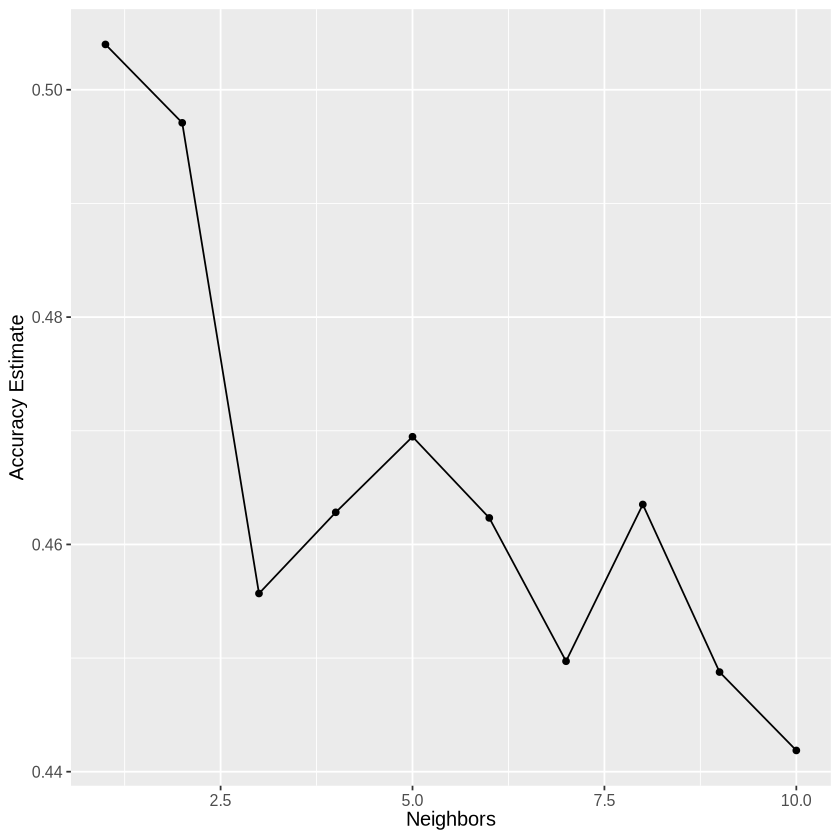

In [58]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))
accuracy_vs_k

In [59]:
best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k

[1] 1

Setting the number of neighbors to K = 19 provides the highest cross-validation accuracy estimate.

Now, we can evaluate our classifier on the test set!

In [60]:
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4965517
Best kernel: rectangular
Best k: 2

In [61]:
players_test_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test) 

In [62]:
players_test_predictions |> metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5714286


.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,0.0,19
TRUE,FALSE,0.0,22
TRUE,TRUE,0.6,19
TRUE,TRUE,0.6,28
FALSE,FALSE,0.0,23
TRUE,TRUE,0.4,20
FALSE,TRUE,0.1,17
TRUE,TRUE,0.1,23
TRUE,TRUE,0.1,15


In [63]:
players_test_predictions |> precision(truth = subscribe, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2777778


In [64]:
players_test_predictions |> recall(truth = subscribe, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.3846154


In [56]:
confusion <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     5   13
     TRUE      8   23

- The classifier achieved an accuracy of about 71.4%, meaning it correctly predicted subscription status for about 71.4% of players.
- Both the classifier's precision and recall are 0, suggesting how the model struggled with correctly identifying the minority class.
- The confusion matrix shows that the classifier predicted "TRUE" for almost all cases, suggesting that the model relies a lot on the majority class.

Therefore, based on the results, **age** and **played_hours** are not strong predictors to subscription status (**subscribe**).